<img width="1000" style="float:center;" src="figures/Heading_tutorial.png"/>

<h1 align="center"><font size="7" face="arial" color="#000000">Simulate an epilepsy surgery</font></h1>

<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">Julie Courtiol</font></span></h3>

<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial"><a href="mailto:courtiol.julie@gmail.com">courtiol.julie@gmail.com</a></font></span></h3>

<h1><font size="6" face="arial" color="#386766">Pre-requisite</font></h1>

---
<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
<ul>
    <li>Simulate an epileptic patient brain tutorial</li>
</ul></font></div></p>

<h1><font size="6" face="arial" color="#386766">Context</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
<ul>
<li><b>Epilepsy</b> is one of the most common neurological disorder that is defined by the occurrence of repetitive unexpected seizures. These epileptic seizures, characterized as abnormal synchronization of neural activities, originate in a specific set of brain regions, known as the <b>Epileptique Zone (EZ)</b>, and propagate to other regions, the <b>Propagation Zone (PZ)</b>, through inter-regional structural interactions, i.e., individual brain connectome, and produce various ictal symptoms depending on the recruited brain regions.</li><br>
    
<li>Approximately 30% of patients suffering from focal seizures are refractory to medication, hence <b>surgical intervention</b>, which consists in the removal of the EZ, is considered as an alternative treatment.</li><br>
</ul></font></div></p>

<br><h1><font size="6" face="arial" color="#386766">Objective</font></h1>

---

<p><div style="text-align: justify"><font size="4.5" face="time roman">The main goal of this hands-on is to provide a clear understanding of <b>how we can reproduce clinically relevant scenarios</b> such as the surgical resection of the Epileptogenic Zone.</font></div></p>

<br><h1><font size="6" face="arial" color="#386766">How to do it with TVB?</font></h1> 

---

<p><div style="text-align: justify"><font size="4.5" face="time roman">The first thing we need to do, is to import the necessary TVB modules and some additional Python packages to perform the simulation and visualize our results.</font></div></p>

In [2]:
# Online visualization.
%pylab nbagg

# Import tvb library.
from tvb.simulator.lab import *
import tvb.datatypes.projections as projections

# Import a bunch of stuff to ease command line usage.
import os
import numpy as np
import time as tm

Populating the interactive namespace from numpy and matplotlib


<h1><font size="6" face="arial" color="black">1. Resection of brain regions</font></h1>
<br>
<p><div style="text-align: justify"><font size="4.5" face="time roman">Epilepsy surgery is used for around 20% of patients whose seizures are drug-resistant. We will simulate the hypothetic case of a <b>surgical resection of the Epileptogenic Zone</b>.</font></div></p><br>

<p><div style="text-align: justify"><font size="4.5" face="time roman">In the following, we will model the epilepsy surgery of the patient suffering from a bilateral temporal lobe epilepsy (TLE), as defined in the tutorial "Simulate an epileptic patient brain". To this end, we will re-load the previous files the files from our local copy. To follow, change the path to the location of the dataset on your machine:</font></div></p>

In [4]:
datadir = "/Applications/TVB_Distribution/my_tvb_materials/TVB_NODES/TVB Node 10/my_pres/notebook/dataset/"

<p><div style="text-align: justify"><font size="4.5" face="time roman">We set all the <b>connections to the Epileptogenic Zone to 0</b> in the connectivity matrix. The resection of the Epileptogenic Network is not complete, will it be enough to prevent seizures?</font></div></p>

In [5]:
# Re-initialise the Connectivity.
con = connectivity.Connectivity.from_file(os.path.join(datadir,"connectivity_76.zip"))       
nregions = len(con.areas)                                  #number of regions
con.weights = con.weights - con.weights * np.eye(nregions) #remove self-connections
con.weights = con.weights / np.abs(con.weights.max())      #normalize
con.speed = np.inf                                         #set the conduction speed to infinity (no time delays)
con.configure()

WARNING  File 'hemispheres' not found in ZIP.


<IPython.core.display.Javascript object>


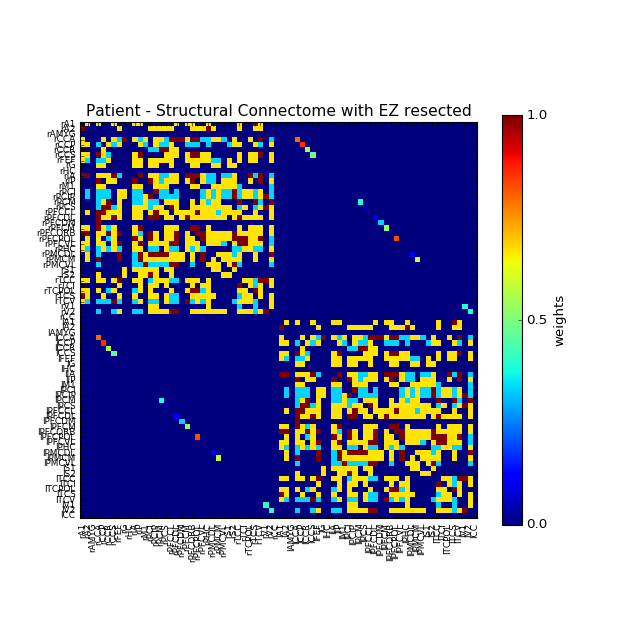

In [6]:
# Resect EZ nodes
# All the incoming and outcoming connections of the resected regions are removed:
con.weights[:, [9, 47, 2, 40]] = 0.
con.weights[[9, 47, 2, 40], :] = 0.
con_lesion = con
con_lesion.configure()

# Visualization of the resected connectome.
figure(figsize=(8,8))
imshow(con_lesion.weights, interpolation='nearest', aspect='equal', cmap='jet')
title('Patient - Structural Connectome with EZ resected', fontsize=14)
cb=colorbar(shrink=0.8, ticks=[0, 0.5, 1])
cb.set_label('weights')
xticks(range(0, nregions), con.region_labels, fontsize=8, rotation=90)
yticks(range(0, nregions), con.region_labels, fontsize=8)

show()

<h1 align="left"><font size="6"face="arial" color="black">2. Simulate</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can now relaunch our first simulation, taking care of replacing the dynamic of the <b>EZ by a stable node</b>, as if the region was resected. The rest of the model is set as before, but we only use a time average monitor.</font></div></p>

In [7]:
# Initialise the Model.
epi = models.Epileptor(Ks=1., r=0.00015)

# Define heatmap.
epi.x0 = np.ones(nregions) * (-2.6)       #NEZ
epi.x0[[62]] = np.ones((1)) * (-1.78)     #PZ 
epi.x0[[70]] = np.ones((1)) * (-1.81)     #PZ 

# Set initial conditions.
epi.state_variable_range["x1"] = [-5, -3]
epi.state_variable_range["y1"] = [-50, -50]
epi.state_variable_range["z"] = [4., 6.]
epi.state_variable_range["x2"] = [-1.1, 1.1]
epi.state_variable_range["y2"] = [0.001, 0.01]

<p><div style="text-align: justify"><font size="4.5" face="time roman">We can then configure and run the <b>Simulator</b>.</font></div></p>

In [9]:
# Initialise the Simulator.
G = -0.25      #global (long-range) coupling strength
dt = 0.05               #integration steps [ms]
nsigma = 0.00025        #standard deviation of the noise

sim = simulator.Simulator(connectivity=con_lesion,
                          conduction_speed=np.float(con_lesion.speed),
                          model=epi,
                          coupling=coupling.Difference(a=G),
                          integrator=integrators.HeunStochastic(dt=dt, noise=noise.Additive(nsig=np.array([0., 0., 0., nsigma, nsigma, 0.])) ),
                          monitors=monitors.TemporalAverage(period=1))

sim.configure()

Parameter,Value,Description
initial_conditions,None,"Initial conditions from which the simulation will begin. By default, random initial conditions are provided. Needs to be the same shape as simulator 'history', ie, initial history function which defines the minimal initial state of the network with time delays before time t=0. If the number of time points in the provided array is insufficient the array will be padded with random values based on the 'state_variables_range' attribute."
coupling,Difference(a=-0.25),The coupling function is applied to the activity propagated between regions by the ``Long-range connectivity`` before it enters the local dynamic equations of the Model. Its primary purpose is to 'rescale' the incoming activity to a level appropriate to Model.
stimulus,None,"A ``Spatiotemporal stimulus`` can be defined at the region or surface level. It's composed of spatial and temporal components. For region defined stimuli the spatial component is just the strength with which the temporal component is applied to each region. For surface defined stimuli, a (spatial) function, with finite-support, is used to define the strength of the stimuli on the surface centred around one or more focal points. In the current version of TVB, stimuli are applied to the first state variable of the ``Local dynamic model``."
integrator,"HeunStochastic(dt=0.05, noise=Additive(dt=0.05, ntau=0))",A tvb.simulator.Integrator object which is an integration scheme with supporting attributes such as integration step size and noise specification for stochastic methods. It is used to compute the time courses of the model state variables.
surface,None,"By default, a Cortex object which represents the cortical surface defined by points in the 3D physical space and their neighborhood relationship. In the current TVB version, when setting up a surface-based simulation, the option to configure the spatial spread of the ``Local Connectivity`` is available."
connectivity,"Connectivity(bound=False, value=None)","A tvb.datatypes.Connectivity object which contains the structural long-range connectivity data (i.e., white-matter tracts). In combination with the ``Long-range coupling function`` it defines the inter-regional connections. These couplings undergo a time delay via signal propagation with a propagation speed of ``Conduction Speed``"
conduction_speed,inf,Conduction speed for ``Long-range connectivity`` (mm/ms)
simulation_length,1000.0,The length of a simulation (default in milliseconds).
model,"Epileptor(bound=False, value=None)","A tvb.simulator.Model object which describe the local dynamic equations, their parameters, and, to some extent, where connectivity (local and long-range) enters and which state-variables the Monitors monitor. By default the 'Generic2dOscillator' model is used. Read the Scientific documentation to learn more about this model."
monitors,"[TemporalAverage(bound=False, value=None)]","A tvb.simulator.Monitor or a list of tvb.simulator.Monitor objects that 'know' how to record relevant data from the simulation. Two main types exist: 1) simple, spatial and temporal, reductions (subsets or averages); 2) physiological measurements, such as EEG, MEG and fMRI. By default the Model's specified variables_of_interest are returned, temporally downsampled from the raw integration rate to a sample rate of 1024Hz."


In [10]:
# Starting simulation
print("Starting simulation...")
tic = tm.time()

(ttavg_, tavg_), = sim.run(simulation_length=10000)

# Finished simulation. 
print("Finished simulation.")
print("execute for" + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for51.785490036


<h1 align="left"><font size="6"face="arial" color="black">3. Visualize our results</font></h1>

<IPython.core.display.Javascript object>


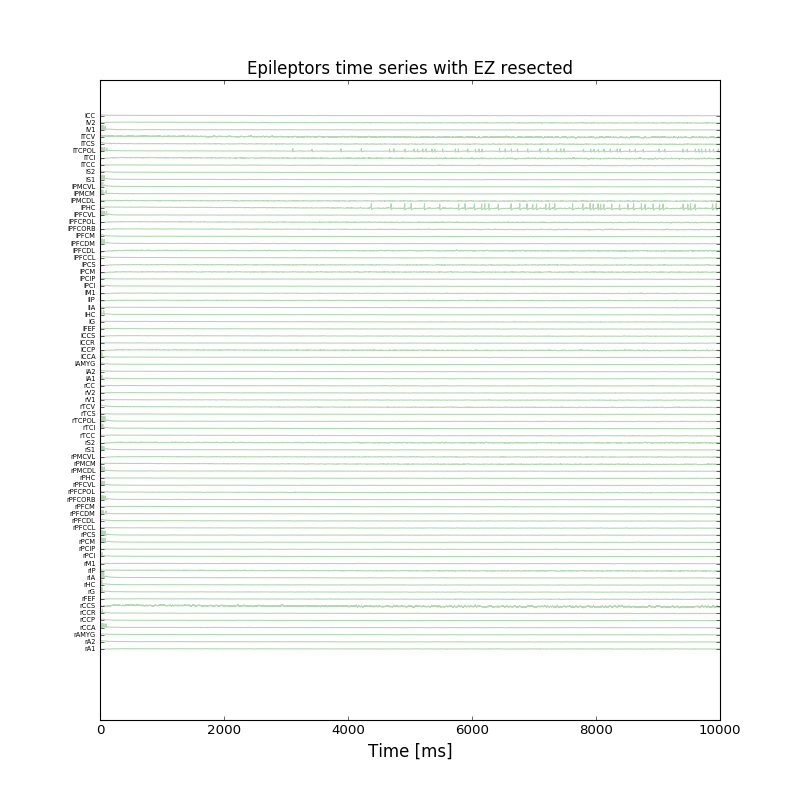

In [11]:
# Normalize the time series to have nice plots.
tavg_ /= (np.max(tavg_,0) - np.min(tavg_,0 ))
tavg_ -= np.mean(tavg_, 0)

# Plot time series.
figure(figsize=(10,10))
plot(ttavg_[:], tavg_[:, 0, :, 0] + np.r_[:nregions], 'g', alpha=0.3)
title('Epileptors time series with EZ resected', fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(con.region_labels)), con.region_labels, fontsize=6)
show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">As you can see, no seizure is triggered anymore.</font></div></p>

<h1><font size="6" face="arial" color="##000000">That is all folks</font></h1>

***

<p><div style="text-align: justify"><font size="4.5" face="time roman">I hope this has been a useful tutorial and welcome any comments or questions.</font></div></p>